# Real-time carbon accounting and material transition for hydrogen systems

__author__ = "Marco De Sousa"
__copyright__ = "Copyright 2023, Multi-parametric Optimization & Control Lab"
__credits__ = ["Marco De Sousa", "Rahul Kakodkar", "Efstratios N. Pistikopoulos"]
__license__ = "MIT"
__version__ = "1.1.0"
__maintainer__ = "Marco De Sousa"
__email__ = "marcopdsousa@tamu.edu"
__status__ = "Production"


## Problem Statement

### The following problem consists over four hydrogen production technologies:

(i) Steam Methane Reforming w\wo CCS

(ii) Autothermal Reforming w\wo CCS

(iii) Proton Exchange Membrane Electrolyzer

(iv) Alkaline Water Electrolyzer

### These hydrogen systems can be powered by three different power suppliers:

(i) Large Grid Supplier with no capacity on production

(ii) Power Purchase Agreements with a supplier utilizing only solar farms

(iii) Power Purchase Agreements with a supplier utilizing only wind farms

## Nomenclature

SMR - Steam Methane Reformer

ATR - Autothermal Reformer

PEM - Proton Exchange Membrane

AWE - Alkaline Water Electrolyzer

CCS - Carbon Capture and Storage

PPA - Power Purchase Agreement

## MILP Formulation

## Import Modules

In [1]:
import sys
sys.path.append('../src')

In [2]:
import pandas as pd
import numpy
from energiapy.components.temporal_scale import TemporalScale
from energiapy.components.resource import Resource, VaryingResource, Scope
from energiapy.components.process import Process, VaryingProcess
from energiapy.components.material import Material
from energiapy.components.location import Location
from energiapy.components.network import Network
from energiapy.components.scenario import Scenario
from energiapy.components.transport import Transport
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.utils.nsrdb_utils import fetch_nsrdb_data
from energiapy.plot import plot_results, plot_scenario
from energiapy.plot.plot_results import CostY, CostX
from energiapy.model.solve import solve
from itertools import product
from energiapy.components.result import Result
from itertools import product
from matplotlib import rc
import matplotlib.pyplot as plt
from energiapy.model.solve import solve
from energiapy.plot.plot_results import CostY, CostX
from energiapy.components.location import Location
from energiapy.plot import plot_results, plot_scenario
from energiapy.utils.nsrdb_utils import fetch_nsrdb_data
from energiapy.model.formulate import formulate, Constraints, Objective
from energiapy.model.bounds import CapacityBounds
from energiapy.utils.data_utils import get_data, make_henry_price_df, remove_outliers, load_results
from energiapy.conversion.photovoltaic import solar_power_output
from energiapy.conversion.windmill import wind_power_output
from energiapy.model.constraints.integer_cuts import constraint_block_integer_cut, constraint_block_integer_cut_min

## Setting up our time horizon and our time discretization

We set our horizon for one day which represents one day into the future

In [3]:
horizon = 1

We discretize our temporal scale of one day into 24 hours

In [4]:
scales = TemporalScale(discretization_list=[1, 24])

We utilize the Big M formulation within our model 

In [6]:
bigM = 10**8
smallM = 0.001

## Introducing our historical data into the model

### Hourly electricity prices of the grid supplier

In [7]:
elec_price_df = pd.read_csv('C:/Users/marcopdsousa/Documents/energiapy/Real-Time/RT 20 AUGUST 2024.csv')
elec_price_df = elec_price_df[['DAM Houston']].reset_index(drop = True)
elec_price_df = elec_price_df[:24]
elec_price_df

,DAM Houston
0,20.23
1,18.38
2,16.45
3,15.96
4,16.32
5,17.54
6,18.60
7,17.52
8,14.98
9,15.74


### Hourly natural gas prices available for purchase on an hourly time scale

In [8]:
#The natural gas price is calculated as the average between the high and low cost, also the unit used is $/kg of natural gas
NG_price_df = pd.read_csv('C:/Users/marcopdsousa/Documents/energiapy/Real-Time/RT 20 AUGUST 2024.csv')
# NG_price_df = pd.DataFrame(NG_price_df['USD/kg'])[::-1].reset_index()
NG_price_df = NG_price_df[['NG_Price']]
NG_price_df = NG_price_df[:24]
NG_price_df

,NG_Price
0,0.140173
1,0.140681
2,0.140173
3,0.140173
4,0.139665
5,0.138649
6,0.140681
7,0.140681
8,0.143220
9,0.143728


### Introducing a time varying emission factor of the grid supplier, as the grid mix adapts, the carbon intensity changes as well

In [10]:
GWP_df = pd.read_csv('C:/Users/marcopdsousa/Documents/energiapy/Real-Time/RT 20 AUGUST 2024.csv')
GWP_df = GWP_df[['GWP']]
GWP_df = GWP_df[:24].reset_index(drop = True)
GWP_df

,GWP
0,348.311221
1,334.372762
2,328.714281
3,320.358485
4,318.604407
5,331.342764
6,352.817494
7,366.807309
8,347.579346
9,300.723807


### Noting the maximum values observed of the three respective datasets

In [ ]:

elec_price = elec_price_df.max()[0]
NG_price = NG_price_df.max()[0]
GWP_value = GWP_df.max()[0]


C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_13808\2629842020.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elec_price = elec_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_13808\2629842020.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NG_price = NG_price_df.max()[0]
C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_13808\2629842020.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  GWP_valu

### Wind availability for power generation through the wind powered PPA

In [12]:
Wind_df = pd.read_csv('C:/Users/marcopdsousa/Documents/energiapy/Real-Time/RT 20 AUGUST 2024.csv')
Wind_df = Wind_df[['WGRPP_HO']]
Wind_df = Wind_df[:24]
Wind_df

,WGRPP_HO
0,320.8
1,287.9
2,230.4
3,131.1
4,58.8
5,41.1
6,15.0
7,15.1
8,10.0
9,2.0


### Solar availability for power generation through the solar powered PPA

In [13]:
Solar_df = pd.read_csv('C:/Users/marcopdsousa/Documents/energiapy/Real-Time/RT 20 AUGUST 2024.csv')
Solar_df = Solar_df[['PVGRPP_HO']]
Solar_df = Solar_df[:24]
Solar_df

,PVGRPP_HO
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
5,0.0
6,0.0
7,109.2
8,777.6
9,1633.4


## Declare Resources - Here we define all resource flow in and out of the system

In [14]:
# We start off with our energy generating resources

Solar = Resource(name='Solar', cons_max=bigM, basis='MW', label='Solar Power', price= 52.69, gwp=0, scope=Scope.TWO)

Wind = Resource(name='Wind', cons_max=bigM, basis='MW', label='Wind Power', price= 60.11, gwp=0, scope=Scope.TWO)

GridPower = Resource(name='GridPower', basis='MW',
                     cons_max=bigM, label='Power bought', gwp= GWP_value, price =elec_price ,varying = [VaryingResource.DETERMINISTIC_PRICE, VaryingResource.DETERMINISTIC_GWP], scope = Scope.TWO)

# Power is the universal resource that the above three equate to, this will be the standardized resource for energy 

Power = Resource(name='Power', basis='MW',
                 label='Power generated')

#----------------------------------------------------------------------------------------------------------------------------

# Below are the different carbon dioxide resources that are used in the process

CO2 = Resource(name='CO2', basis='kg/hr',
               label='Carbon dioxide', block='Resource')

CO2_Stack = Resource(name='CO2 to Stack', basis='kg/hr', sell=True,
               label='Carbon dioxide to Stack', block='Resource', gwp = 1, scope = Scope.ONE)

CO2_Air = Resource(name='CO2 from air', basis='kg/hr',
               label='Carbon dioxide from air', block='Resource', cons_max=bigM)

CO2_Vent = Resource(name='CO2 Vented from the process', basis='kg/hr',
               label='Carbon dioxide vented from the process', block='Resource', gwp = 1, sell=True, scope = Scope.ONE)

CO2cpt = Resource(name='CO2 Captured', basis='kg/hr', sell=True, label='Captured carbon dioxide', block='Resource')

CO2_Blowdown= Resource(name='CO2 Blowdown', basis='kg/hr', block='Resource', sell = True, gwp = 1) 

#----------------------------------------------------------------------------------------------------------------------------



#----------------------------------------------------------------------------------------------------------------------------

# Hydrogen is what I want to sell/satisfy a specific demand for

H2 = Resource(name='Hydrogen', basis='kg/hr', label='Hydrogen', block='Resource')

H2Pure = Resource(name='Pure Hydrogen', demand = True, basis='kg/hr', label='Pure Hydrogen', block='Resource')

#----------------------------------------------------------------------------------------------------------------------------

# Water that is required for electrolyzer process, also not that there are different sources of water that are used in the process

H2O = Resource(name='H2O',
               basis='kg/hr', cons_max=bigM, label='Water', block='Resource')

#Industrial water price is 0.002 USD/kg of water
H2OFresh = Resource(name="H2O Fresh", cons_max=bigM, price = 0.002, basis='kg/hr', label='Fresh Water', block='Resource')

H2O_Air = Resource(name='H2O from air', cons_max=bigM,
               basis='kg/hr', label='Water from air', block='Resource')

H2O_Vent = Resource(name='H2O vented from the process',
               basis='kg/hr', sell=True, label='Water vented from the process', block='Resource')


H2O_Stack = Resource(name='H2O to Stack',
               basis='kg/hr', sell= True, label='Water to Stack', block='Resource')

H2O_Vent_ASU = Resource(name='H2O Vent from ASU',
               basis='kg/hr', sell= True, label='Water vented from ASU', block='Resource')

H2O_Blowdown = Resource(name='H2O in Blowdown',
               basis='kg/hr', sell= True, label='H2O present in air - Stream 5', block='Resource') 


#----------------------------------------------------------------------------------------------------------------------------

# Air components

N2 = Resource(name='N2', basis='kg/hr',
               label='Nitrogen', block='Resource')

N2_SMR = Resource(name='N2 from SMR', basis='kg/hr',
               label='Nitrogen from SMR', block='Resource')

N2_WGS = Resource(name='N2 from WGS', basis='kg/hr',
               label='Nitrogen from WGS', block='Resource')

N2_FG = Resource(name='N2 from FG', basis='kg/hr',
               label='Nitrogen from FG', block='Resource')

N2_Air = Resource(name='N2 from Air', basis='kg/hr', cons_max= bigM,
               label='Nitrogen from Air', block='Resource')

N2_Vent = Resource(name='N2 vented from the process', basis='kg/hr', sell= True,
               label='Nitrogen vented from the process', block='Resource')

N2Prod = Resource(name='N2 in product stream', basis='kg/hr', sell = True,
               label='Nitrogen in product stream', block='Resource')

N2_Stack = Resource(name='N2 to Stack', basis='kg/hr', sell= True,
               label='Nitrogen to stack', block='Resource')

N2_Desorped = Resource(name='N2 Desorped', basis='kg/hr', sell = True,
               label='Nitrogen in CO2 desorption stream', block='Resource')

N2_Vented_Stack = Resource(name='N2 in Stack', basis='kg/hr', sell = True,
               label='Nitrogen in Stack', block='Resource')

N2_Blowdown = Resource(name='N2 in Blowdown', basis='kg/hr', sell = True,
               label='Nitrogen in Blowdown stream', block='Resource') 

O2 = Resource(name='O2', basis='kg/hr',
               label='Oxygen', block='Resource')

O2_Air = Resource(name='O2 from air', basis='kg/hr',
               label='Oxygen from air', block='Resource', cons_max = bigM)

O2_Vent = Resource(name='O2 vented from the process', basis='kg/hr', sell=True,
               label='Oxygen vented from the process', block='Resource')

O2_Stack = Resource(name='O2 to Stack', basis='kg/hr', sell= True,
               label='Oxygen to Stack', block='Resource')

O2_Desorped = Resource(name='O2 Desorped', basis='kg/hr',
               label='Oxygen in CO2 desorption stream', block='Resource')

O2_ASU = Resource(name='O2 vented out of ASU', basis='kg/hr', sell = True,
               label='O2 vented out of ASU', block='Resource')

O2_Blowdown = Resource(name='O2 in Blowdown', basis='kg/hr',
               label='O2 in Blowdown stream', block='Resource')

#----------------------------------------------------------------------------------------------------------------------------

CH4 = Resource(name='CH4', basis='kg/hr', label='Methane', block='Resource')

NG = Resource(name='Natural Gas', basis='kg/hr', cons_max=bigM, label='Natural Gas', gwp = 0.660979, price = NG_price, varying = [VaryingResource.DETERMINISTIC_PRICE])

CH4_Desorped = Resource(name='CH4_Desorped', basis='kg/hr', label='Methane', block='Resource') 


## Declare Processes - Here we define the processes that generate power, produce hydrogen, capture carbon, etc.

In [ ]:
'''Purchasing electricity from a traditional power production system'''

Grid = Process(name='Grid', conversion={GridPower: -1, Power: 1}, prod_min=smallM, prod_max=bigM, label='Grid', basis='MW')

PV = Process(name='PV', conversion={Solar: -1, Power: 1},
             prod_max=100, prod_min=100,  varying= [VaryingProcess.DETERMINISTIC_CAPACITY], label='Solar PV', basis='MW')


WF = Process(name='WF', conversion={Wind: -1, Power: 1},
             prod_max=300, prod_min=300, label='Wind mill array', varying=[VaryingProcess.DETERMINISTIC_CAPACITY], basis='MW')


SMR = Process(name='SMR', conversion={Power: -0.00065, NG: -3.535189, H2OFresh: -16.78877421, N2_Air: -19.2134, O2_Air: -5.88716, H2O_Air: -0.1582, CO2_Air: -0.01171, 
                                            H2Pure: 1, CO2_Stack: 9.3713,  H2O_Stack: 3.94959, N2_Stack: 19.29814, O2_Stack: 0.535434}, capex=0.0001,
               vopex=0.84, fopex=0.001, prod_min=smallM, prod_max=20000, label='SMR', basis='kg/hr')

#The CCS system that can be utilized in tandem with the SMR technology

SMRCCS = Process(name='SMRCCS', conversion={Power: -0.00139, N2_Air: -22.2315, O2_Air: -6.811924, H2O_Air: -0.183055, CO2_Air: -0.013551, CO2_Stack: -9.3713,
                                             H2O_Vent: 3.826767, CO2cpt: 8.903, CO2_Vent: 0.46856, H2O_Stack: 0.558114, N2_Stack: 22.32218, O2_Stack: 0.6203032, }, capex=0.0001,
                vopex=1.1, fopex=0.001, prod_min=smallM, prod_max=bigM, label='SMRCCS', basis='kg/hr')


ATR_CCS_R = Process(name='ATR_CCS_R', conversion= {Power: -0.00175403726, NG: -3.2080287, H2OFresh: -4.8123228, H2O_Air : -0.1041653, H2O_Blowdown : 1.7351222, H2O_Vent : 0.5239897,
                                                   N2_Air: -12.653394, N2_Vent: 9.970844643, N2Prod: 0.002780318, N2_Vented_Stack: 2.182324573, N2_Desorped: 0.023329689, O2_Air: -3.87607534,
                                                   O2_ASU: 0.061984387, O2_Vent: 0.0647028, CO2_Air:-0.007711159, CO2_Vent: 0.457276602, CO2cpt: 7.733322317, H2Pure: 1}, capex=0.0001,
               vopex=0.82, fopex=0.001, prod_min=smallM, prod_max=20000, label='ATR_CCS_R', basis='kg/hr')

ATR_CCS_OC = Process(name='ATR_CCS_OC', conversion={Power: -0.0059130434, NG: -3.584338787, CO2_Air: -0.010770164, CO2_Blowdown: 0.11601384, CO2cpt: 9.192057517, N2_Air: -17.67297545, N2_Vent: 16.7175342, 
                                                    N2_Blowdown: 0.000797082, N2_Desorped: 0.131330546, N2Prod: 0.002780318,
                                                    H2O_Air: -0.145487576, H2OFresh: -5.377267146, H2O_Vent_ASU: 0.003250534, H2O_Blowdown: 3.598489736, O2_Air: -6.758549377, O2_Vent: 0.10392561, H2Pure: 1}, capex=0.0001,
               vopex=0.87, fopex=0.001, prod_min=smallM, prod_max=20000, label='ATR_CCS_OC', basis='kg/hr')

ATR_CCS_R_OC = Process(name='ATR_CCS_R_OC', conversion={Power: -0.00203229813, NG: -3.208028688, CO2_Air: -0.007656042, CO2_Blowdown: 0.671400596, CO2cpt: 8.152141983, 
                                                        N2_Air: -12.56295099, N2_Vent: 11.88406435, N2_Blowdown: 0.008434949, N2_Desorped: 0.102417105, N2Prod: 0.002780318, 
                                                        H2OFresh: -4.812322829, H2O_Air: -0.103420802, H2O_Vent_ASU: 0.002310721, H2O_Blowdown: 0.004504513, O2_Air: -4.804359335, 
                                                        O2_Vent: 0.073878039, H2Pure: 1}, capex=0.0001,
               vopex=0.85, fopex=0.001, prod_min=smallM, prod_max=20000, label='ATR_CCS_R_OC', basis='kg/hr')

AWE = Process(name='AWE', conversion={Power: -0.05, H2OFresh: -9.4635, H2Pure: 1}, capex=0.0001,vopex=4.250633, fopex=0.001, prod_min=smallM, prod_max=18.75, label='AWE', basis='kg/hr')

PEM = Process(name='PEM', conversion={Power: -0.064, H2OFresh: -9.5,
                                            H2Pure: 1}, capex=0.0001,
               vopex=3.73, fopex=0.001, prod_min=smallM, prod_max=18.75, label='PEM', basis='kg/hr')

### Declare Process Set - Here include every process that needs to be considered within the optimization model

In [17]:
process_set = {Grid, PV, WF, AWE, ATR_CCS_R, ATR_CCS_OC, ATR_CCS_R_OC, SMRCCS, PEM, SMR} 

### Declare Location - Here we define which location the case study is carried out in, in this example we used the historical data from the Houston, TX region.

In [18]:
houston = Location(name='HO', processes=process_set,  price_factor={GridPower: elec_price_df, NG: NG_price_df}, gwp_factor={GridPower: GWP_df}, capacity_factor={PV: Solar_df, WF: Wind_df},
                   scales=scales, label='Houston', expenditure_scale_level=0, demand_scale_level=0, price_scale_level=1, gwp_scale_level = 1, capacity_scale_level=1)


### Declare Scenario - This is done after defining our location, now we set the demand for our Hydrogen product. If facing a multi-locational problem we would setup a network of different defined locations

In [19]:

scenario = Scenario(name='scenario_full', network=houston, scales=scales,  expenditure_scale_level=0, demand_scale_level=0, 
                    purchase_scale_level = 1, scheduling_scale_level=1, network_scale_level=0, capacity_scale_level=1, gwp_scale_level = 1, 
                    label='full_case', demand={houston: {H2Pure:240000}})



The following is to visualize to changing electricity prices and emission factor of the Grid supplier in Houston which is known as ERCOT. Additional visualizations are made for varying natural gas prices and renewable availability

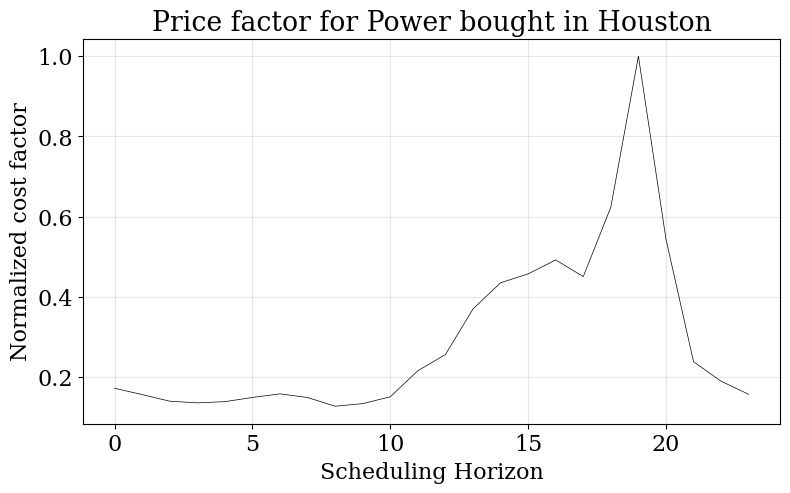

In [23]:

plot_scenario.price_factor(
    scenario=scenario, location=houston, resource=GridPower, fig_size=(9, 5), color='black')


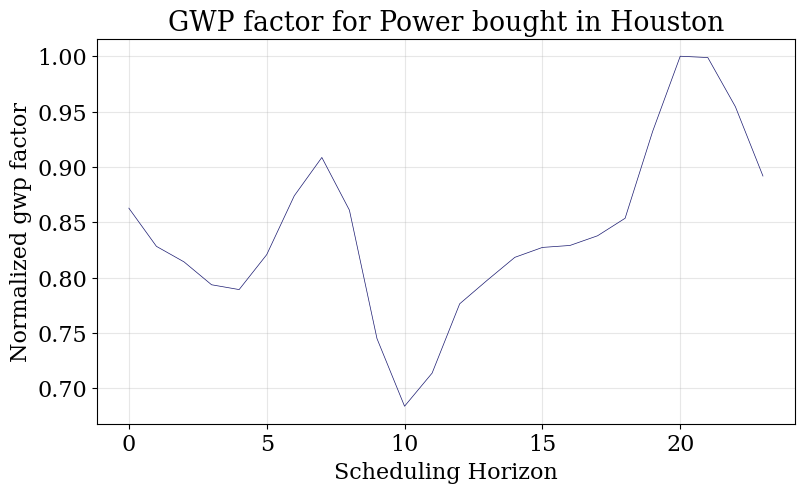

In [24]:
plot_scenario.gwp_factor(
    scenario=scenario, location=houston, resource=GridPower, fig_size=(9, 5), color='midnightblue')

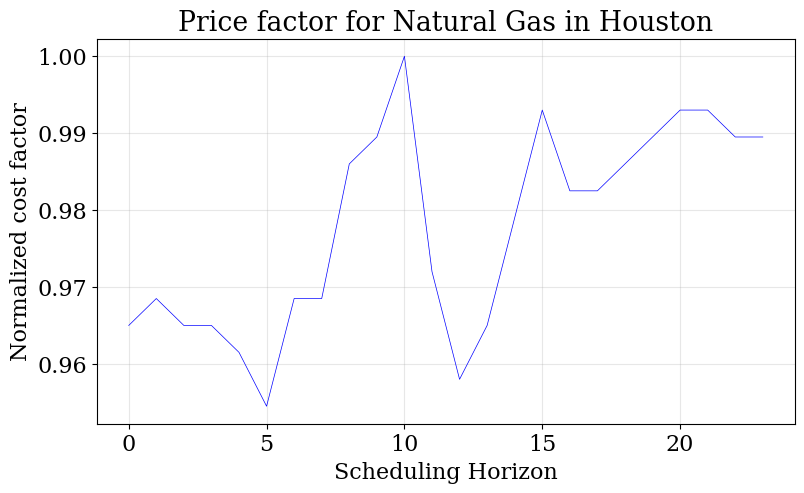

In [25]:

plot_scenario.price_factor(
    scenario=scenario, location=houston, resource=NG, fig_size=(9, 5), color='blue')

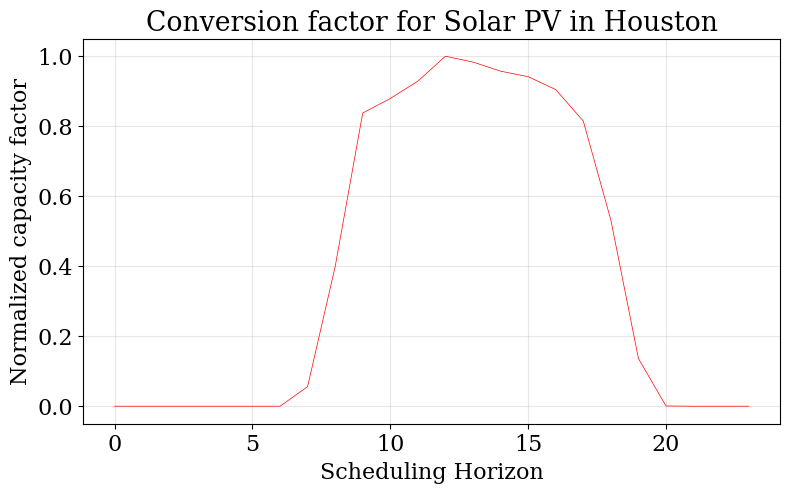

In [26]:
plot_scenario.capacity_factor(
    scenario=scenario, location=houston, process=PV, fig_size=(9, 5), color='red')

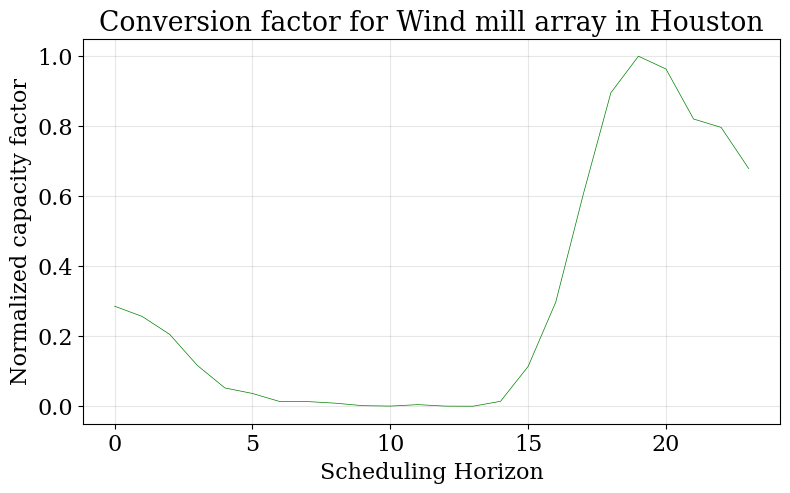

In [27]:
plot_scenario.capacity_factor(
    scenario=scenario, location=houston, process=WF, fig_size=(9, 5), color='green')

## Formulate MILP

The problem is formulated below with the objective to minimize overall cost

In [28]:
#, Constraints.MODE

milp_cost = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                      Constraints.RESOURCE_BALANCE, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint production mode
constraint inventory balance
constraint inventory network
constraint demand
objective cost


### Ramping constratints are added to both SMR and ATR Technologies

In [28]:
# #model.component

from pyomo.environ import ConstraintList

ramping_limit = 1000

milp_cost.cons2 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_cost.cons2.add(expr = milp_cost.P['HO', 'SMR', *i] - milp_cost.P['HO', 'SMR', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_cost.cons3 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_cost.cons3.add(expr = milp_cost.P['HO', 'SMR', *i] - milp_cost.P['HO', 'SMR', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] >= -ramping_limit)




In [32]:
from pyomo.environ import ConstraintList



ramping_limitATR = 2000

milp_cost.cons4 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_cost.cons4.add(expr = milp_cost.P['HO', 'ATR_CCS_R', *i] - milp_cost.P['HO', 'ATR_CCS_R', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limitATR)

milp_cost.cons5 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_cost.cons5.add(expr = milp_cost.P['HO', 'ATR_CCS_R', *i] - milp_cost.P['HO', 'ATR_CCS_R', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] >= -ramping_limitATR)

milp_cost.cons6 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_cost.cons6.add(expr = milp_cost.P['HO', 'ATR_CCS_OC', *i] - milp_cost.P['HO', 'ATR_CCS_OC', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limitATR)

milp_cost.cons7 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_cost.cons7.add(expr = milp_cost.P['HO', 'ATR_CCS_OC', *i] - milp_cost.P['HO', 'ATR_CCS_OC', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] >= -ramping_limitATR)        

milp_cost.cons8 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_cost.cons8.add(expr = milp_cost.P['HO', 'ATR_CCS_R_OC', *i] - milp_cost.P['HO', 'ATR_CCS_R_OC', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limitATR)

milp_cost.cons9 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_cost.cons9.add(expr = milp_cost.P['HO', 'ATR_CCS_R_OC', *i] - milp_cost.P['HO', 'ATR_CCS_R_OC', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] >= -ramping_limitATR)  

In [33]:
results_cost = solve(scenario=scenario, instance=milp_cost,
                     solver='gurobi', name=f"res_cost", print_solversteps=True, saveformat = '.pkl')


Set parameter QCPDual to value 1
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 3205 rows, 15277 columns and 8747 nonzeros
Model fingerprint: 0xe8ab870e
Coefficient statistics:
  Matrix range     [1e-04, 4e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-03, 1e+08]
Presolve removed 2872 rows and 15016 columns
Presolve time: 0.01s
Presolved: 333 rows, 353 columns, 1202 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.0354964e+05   2.361350e+05   0.000000e+00      0s
     145    3.1599812e+05   0.000000e+00   0.000000e+00      0s

Solved in 145 iterations and 0.01 seconds (0.01 work units)
Optimal objective  3.159981223e+05


Cost Objective:

In [35]:
results_cost.output['objective']

315998.12234188966

Global Warming Potential:

In [36]:
results_cost.output['global_warming_potential_location']

{('HO', 0): 757128.8793809507}

Global Warming Potential from different resources:

In [37]:
results_cost.output['global_warming_potential_resource']

{('HO', 'CO2 Blowdown', 0, 0): 0.0,
 ('HO', 'CO2 Blowdown', 0, 1): 0.0,
 ('HO', 'CO2 Blowdown', 0, 2): 0.0,
 ('HO', 'CO2 Blowdown', 0, 3): 0.0,
 ('HO', 'CO2 Blowdown', 0, 4): 0.0,
 ('HO', 'CO2 Blowdown', 0, 5): 0.0,
 ('HO', 'CO2 Blowdown', 0, 6): 0.0,
 ('HO', 'CO2 Blowdown', 0, 7): 0.0,
 ('HO', 'CO2 Blowdown', 0, 8): 0.0,
 ('HO', 'CO2 Blowdown', 0, 9): 0.0,
 ('HO', 'CO2 Blowdown', 0, 10): 0.0,
 ('HO', 'CO2 Blowdown', 0, 11): 0.0,
 ('HO', 'CO2 Blowdown', 0, 12): 0.0,
 ('HO', 'CO2 Blowdown', 0, 13): 0.0,
 ('HO', 'CO2 Blowdown', 0, 14): 0.0,
 ('HO', 'CO2 Blowdown', 0, 15): 0.0,
 ('HO', 'CO2 Blowdown', 0, 16): 0.0,
 ('HO', 'CO2 Blowdown', 0, 17): 0.0,
 ('HO', 'CO2 Blowdown', 0, 18): 0.0,
 ('HO', 'CO2 Blowdown', 0, 19): 0.0,
 ('HO', 'CO2 Blowdown', 0, 20): 0.0,
 ('HO', 'CO2 Blowdown', 0, 21): 0.0,
 ('HO', 'CO2 Blowdown', 0, 22): 0.0,
 ('HO', 'CO2 Blowdown', 0, 23): 0.0,
 ('HO', 'CO2 Captured', 0, 0): 0.0,
 ('HO', 'CO2 Captured', 0, 1): 0.0,
 ('HO', 'CO2 Captured', 0, 2): 0.0,
 ('HO', 'CO2 C

Process flow on an hourly scale:

In [38]:
results_cost.output['P']

{('HO', 'ATR_CCS_OC', 0, 0): 0.0,
 ('HO', 'ATR_CCS_OC', 0, 1): 0.0,
 ('HO', 'ATR_CCS_OC', 0, 2): 0.0,
 ('HO', 'ATR_CCS_OC', 0, 3): 0.0,
 ('HO', 'ATR_CCS_OC', 0, 4): 0.0,
 ('HO', 'ATR_CCS_OC', 0, 5): 0.0,
 ('HO', 'ATR_CCS_OC', 0, 6): 0.0,
 ('HO', 'ATR_CCS_OC', 0, 7): 0.0,
 ('HO', 'ATR_CCS_OC', 0, 8): 0.0,
 ('HO', 'ATR_CCS_OC', 0, 9): 0.0,
 ('HO', 'ATR_CCS_OC', 0, 10): 0.0,
 ('HO', 'ATR_CCS_OC', 0, 11): 0.0,
 ('HO', 'ATR_CCS_OC', 0, 12): 0.0,
 ('HO', 'ATR_CCS_OC', 0, 13): 0.0,
 ('HO', 'ATR_CCS_OC', 0, 14): 0.0,
 ('HO', 'ATR_CCS_OC', 0, 15): 0.0,
 ('HO', 'ATR_CCS_OC', 0, 16): 0.0,
 ('HO', 'ATR_CCS_OC', 0, 17): 0.0,
 ('HO', 'ATR_CCS_OC', 0, 18): 0.0,
 ('HO', 'ATR_CCS_OC', 0, 19): 0.0,
 ('HO', 'ATR_CCS_OC', 0, 20): 0.0,
 ('HO', 'ATR_CCS_OC', 0, 21): 0.0,
 ('HO', 'ATR_CCS_OC', 0, 22): 0.0,
 ('HO', 'ATR_CCS_OC', 0, 23): 0.0,
 ('HO', 'ATR_CCS_R', 0, 0): 20000.0,
 ('HO', 'ATR_CCS_R', 0, 1): 20000.0,
 ('HO', 'ATR_CCS_R', 0, 2): 20000.0,
 ('HO', 'ATR_CCS_R', 0, 3): 20000.0,
 ('HO', 'ATR_CCS_R', 0

## How would the objective change as we enforce more strict environmental constraints?

In [40]:
from energiapy.model.constraints.emission import constraint_global_warming_potential_network_reduction

In [41]:
from pyomo.environ import Var, Binary

def modeler(gwp_pct: float):
    instance = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                        Constraints.RESOURCE_BALANCE, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

    constraint_global_warming_potential_network_reduction(instance= instance, network_scale_level = 0, gwp_reduction_pct = gwp_pct, gwp = results_cost.output['global_warming_potential_network'][0])

    ramping_limit = 1000

    instance.cons2 = ConstraintList()
    for i in scales.scale_iter(1):
        if i != (0,0):
            instance.cons2.add(expr = instance.P['HO', 'SMR', *i] - instance.P['HO', 'SMR', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

    instance.cons3 = ConstraintList()
    for i in scales.scale_iter(1):
        if i != (0,0):
            instance.cons3.add(expr = instance.P['HO', 'SMR', *i] - instance.P['HO', 'SMR', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] >= -ramping_limit)

    ramping_limitz = 2000

    instance.cons4 = ConstraintList()
    for i in scales.scale_iter(1):
        if i != (0,0):
            instance.cons4.add(expr = instance.P['HO', 'ATR_CCS_R', *i] - instance.P['HO', 'ATR_CCS_R', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limitz)

    instance.cons5 = ConstraintList()
    for i in scales.scale_iter(1):
        if i != (0,0):
            instance.cons5.add(expr = instance.P['HO', 'ATR_CCS_R', *i] - instance.P['HO', 'ATR_CCS_R', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] >= -ramping_limitz)

    instance.cons6 = ConstraintList()
    for i in scales.scale_iter(1):
        if i != (0,0):
            instance.cons6.add(expr = instance.P['HO', 'ATR_CCS_OC', *i] - instance.P['HO', 'ATR_CCS_OC', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limitz)

    instance.cons7 = ConstraintList()
    for i in scales.scale_iter(1):
        if i != (0,0):
            instance.cons7.add(expr = instance.P['HO', 'ATR_CCS_OC', *i] - instance.P['HO', 'ATR_CCS_OC', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] >= -ramping_limitz)        

    instance.cons8 = ConstraintList()
    for i in scales.scale_iter(1):
        if i != (0,0):
            instance.cons8.add(expr = instance.P['HO', 'ATR_CCS_R_OC', *i] - instance.P['HO', 'ATR_CCS_R_OC', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limitz)

    instance.cons9 = ConstraintList()
    for i in scales.scale_iter(1):
        if i != (0,0):
            instance.cons9.add(expr = instance.P['HO', 'ATR_CCS_R_OC', *i] - instance.P['HO', 'ATR_CCS_R_OC', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] >= -ramping_limitz)  

    # Minimum production rate
    # milp_cost.cons1 = ConstraintList()
    # for i in scales.scale_iter(1):
    #  milp_cost.cons1.add(expr = milp_cost.P['HO', 'SMR', *i] >= 1000)

    # Add binary variables for on/off control
    instance.on_smr = Var(scales.scale_iter(1), domain=Binary)  # Binary variable for SMR system
    instance.on_atr_ccs_r = Var(scales.scale_iter(1), domain=Binary)  # Binary variable for ATR_CCS_R system
    instance.on_atr_ccs_oc = Var(scales.scale_iter(1), domain=Binary)  # Binary variable for ATR_CCS_OC system
    instance.on_atr_ccs_r_oc = Var(scales.scale_iter(1), domain=Binary)  # Binary variable for ATR_CCS_R_OC system

    instance.cons10 = ConstraintList()
    for i in scales.scale_iter(1):
        #if i != (0,0):
            instance.cons10.add(expr = instance.P['HO', 'SMR', *i] >= 6000 * instance.on_smr[i]) #30% of max production rate

    instance.cons11 = ConstraintList()
    for i in scales.scale_iter(1):
        #if i != (0,0):
            instance.cons11.add(expr = instance.P['HO', 'ATR_CCS_R', *i] >= 4000 * instance.on_atr_ccs_r[i]) #20% of max production rate
    
    instance.cons12 = ConstraintList()
    for i in scales.scale_iter(1):
        #if i != (0,0):
            instance.cons12.add(expr = instance.P['HO', 'ATR_CCS_OC', *i] >= 4000 * instance.on_atr_ccs_oc[i]) #20% of max production rate

    instance.cons13 = ConstraintList()
    for i in scales.scale_iter(1):
        #if i != (0,0):
            instance.cons13.add(expr = instance.P['HO', 'ATR_CCS_R_OC', *i] >= 4000 * instance.on_atr_ccs_r_oc[i]) #20% of max production rate

    # For SMR
    instance.cons14 = ConstraintList()
    for i in scales.scale_iter(1):
        #if i != (0, 0):
        # Force production to zero if the system is off (on_smr == 0)
            instance.cons14.add(expr = instance.P['HO', 'SMR', *i] <= 20000 * instance.on_smr[i])

# For ATR_CCS_R
    instance.cons15 = ConstraintList()
    for i in scales.scale_iter(1):
        #if i != (0, 0):
        # Force production to zero if the system is off (on_atr_ccs_r == 0)
            instance.cons15.add(expr = instance.P['HO', 'ATR_CCS_R', *i] <= 20000 * instance.on_atr_ccs_r[i])

# For ATR_CCS_OC
    instance.cons16 = ConstraintList()
    for i in scales.scale_iter(1):
        #if i != (0, 0):
        # Force production to zero if the system is off (on_atr_ccs_oc == 0)
            instance.cons16.add(expr = instance.P['HO', 'ATR_CCS_OC', *i] <= 20000 * instance.on_atr_ccs_oc[i])

# For ATR_CCS_R_OC
    instance.cons17 = ConstraintList()
    for i in scales.scale_iter(1):
        #if i != (0, 0):
        # Force production to zero if the system is off (on_atr_ccs_r_oc == 0)
            instance.cons17.add(expr = instance.P['HO', 'ATR_CCS_R_OC', *i] <= 20000 * instance.on_atr_ccs_r_oc[i])


    return instance

In [42]:
models = [modeler(i+1) for i in range(100)]

constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential resource
constraint global warming potential resource consumption


constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint production mode
constraint inventory balance
constraint inventory network
constraint demand
objective cost
constraint global warming potential network reduction
constraint process capex
constraint process fopex
constraint process vopex
constraint process incidental
constraint storage cost
constraint storage cost location
constraint storage cost network
constraint global warming potential resource
constraint global warming potential resource consumption
constraint global warming potential resource discharge
constraint global warming potential location
constraint global warming potential network
constraint production mode
constraint inventory balance
constraint inventory network
constraint demand
objective cost
constraint global warming potential network reduction
constraint process capex
constraint process fopex
constraint process vop

KeyboardInterrupt: 

In [ ]:
def solver(instance, i): 
    return solve(scenario=scenario, instance=instance,
                     solver='gurobi', name=f"res_red/res_red_{i}", print_solversteps=True, saveformat = '.pkl')

In [ ]:
results = {i: solver(m,i) for i,m in enumerate(models)}

Set parameter QCPDual to value 1
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 3398 rows, 15373 columns and 9132 nonzeros
Model fingerprint: 0x4d49ac37
Variable types: 15277 continuous, 96 integer (96 binary)
Coefficient statistics:
  Matrix range     [1e-04, 2e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e-03, 1e+08]
Presolve removed 2804 rows and 15116 columns
Presolve time: 0.00s
Presolved: 594 rows, 257 columns, 1853 nonzeros
Variable types: 253 continuous, 4 integer (4 binary)
Found heuristic solution: objective 524612.54882
Found heuristic solution: objective 500087.09491
Found heuristic solution: objective 347300.00883

Root relaxation: objective 3.173901e+05, 110 iterations, 0.00 seconds (0.00 work units)

    Node

In [ ]:
for i in range(len(models)):
    print(results[i].output['termination'])

optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
optimal
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasible
infeasibl

Visualization of different optimal points as a function of Carbon Intensity vs. Total Hydrogen Cost

<class 'float'>


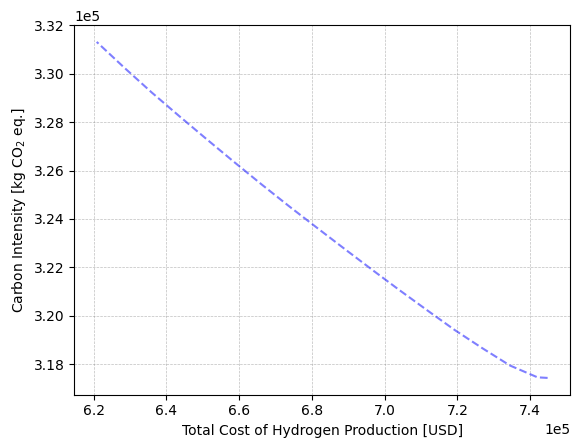

In [ ]:
cost = [None for i in range(len(results))]
gwp_study = [None for i in range(len(results))]
prod_study = [None for i in range(len(results))]


for gwp_red, result in results.items():

    if result.output['termination'] == 'optimal':
        cost[gwp_red] = result.output['objective']
        gwp_study[gwp_red] = result.output['global_warming_potential_location']['HO', 0]
        prod_study[gwp_red] = result.output['P']

print(type(gwp_study[0]))

plt.plot(gwp_study, cost, color='blue', linestyle='--', alpha=0.5)

plt.xlabel('Total Cost of Hydrogen Production [USD]')
plt.ylabel('Carbon Intensity [kg CO$_2$ eq.]')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))  # For x-axis
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))  # For y-axis
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha = 0.5)
# gwp_study[0]


In [ ]:
gwp_study[17]
#prod_study[0] ['HO', 'ATR_CCS_R', 0, 0]

# for gwp_reduction in range(len(results)):
#     if prod_study[gwp_reduction] is not None:
#         plt.plot([prod_study[gwp_reduction]['HO', 'SMR', 0, hour] for hour in range(24)], color = (1 - gwp_reduction/100,gwp_reduction/100,0))


620845.6810923796

### A maximum reduction of 17% has been observed, the energy consumption on an hourly rate is graphed below:

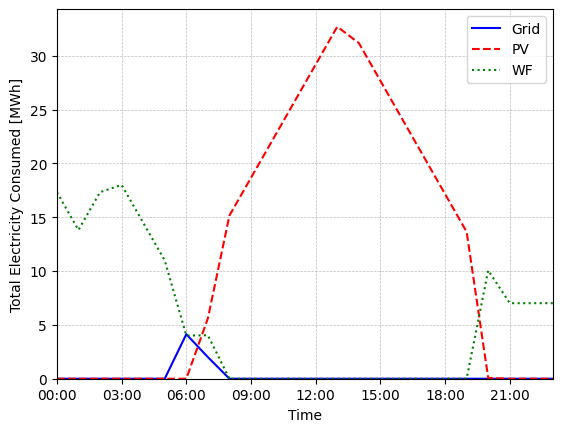

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Generate time labels
time_labels = [datetime(2024, 1, 1) + timedelta(hours=i) for i in range(24)]

# Plotting the data
plt.plot(time_labels, [prod_study[17]['HO', 'Grid', 0, hour] for hour in range(24)], color='blue', label="Grid")
plt.plot(time_labels, [prod_study[17]['HO', 'PV', 0, hour] for hour in range(24)], color='red', linestyle='--', label="PV")
plt.plot(time_labels, [prod_study[17]['HO', 'WF', 0, hour] for hour in range(24)], color='g', linestyle=':', label="WF")


# Labeling axes
plt.xlabel('Time')
plt.ylabel('Total Electricity Consumed [MWh]')

# Format the y-axis in scientific notation
plt.ticklabel_format(style='sci', axis='y')  

# Set limits for y and x axes
plt.ylim(bottom=0)
plt.xlim([time_labels[0], time_labels[-1]])

# Set custom time labels for the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Hour:Minute format
plt.xticks(time_labels[::3])  # Show every second hour for better spacing

# Add grid
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Display legend
plt.legend()

# Show the plot
plt.show()

### The hourly energy consumption rate of the cost minimization (Base case) scenario is plotted to compare with the strict 17% case

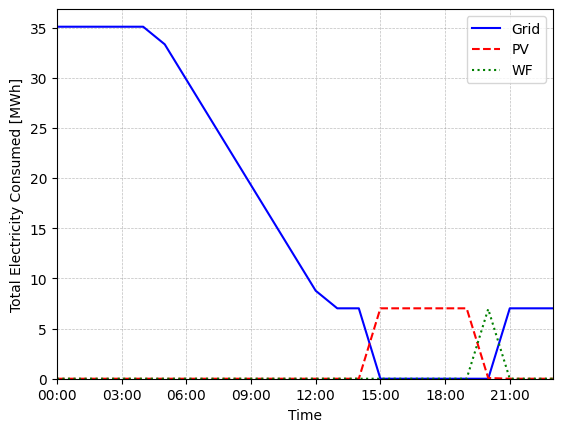

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Generate time labels
#For an entire year of hour data point I should maybe just discretize it into only months??
'''Second discretization is months, do I do a : "for i in range(12), for i in range(24)" so how do I make two time periods talk with each other?'''
time_labels = [datetime(2024, 1, 1) + timedelta(hours=i) for i in range(24)]
#datetime(2024, i, j,k) for i in range(1), for j in range(12), for k in range(24)
'''month_labels = [datetime(2024,1,1) + timedelta(months=i) for i in range(12)]'''

# Plotting the data
'''Example -> plt.plot(time_labels, [prod_study[0]['HO', 'Grid', month, hour] for month in range(12), for hour in range(24)], label="Grid")'''
plt.plot(time_labels, [prod_study[0]['HO', 'Grid', 0, hour] for hour in range(24)], color='blue', label="Grid")
plt.plot(time_labels, [prod_study[0]['HO', 'PV', 0, hour] for hour in range(24)], color='red', linestyle='--', label="PV")
plt.plot(time_labels, [prod_study[0]['HO', 'WF', 0, hour] for hour in range(24)], color='g', linestyle=':', label="WF")


# Labeling axes
plt.xlabel('Time')
plt.ylabel('Total Electricity Consumed [MWh]')

# Format the y-axis in scientific notation
plt.ticklabel_format(style='sci', axis='y')  

# Set limits for y and x axes
plt.ylim(bottom=0)
plt.xlim([time_labels[0], time_labels[-1]])

# Set custom time labels for the x-axis
'''plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Mo?:%D:%H:%M))'''
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Hour:Minute format
plt.xticks(time_labels[::3])  # Show every second hour for better spacing this will have to be extend to show every 6 hours or actually not showing hours at all
'''plt.xticks(month_labels[::2] to show every second month?'''
# Add grid
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Display legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
# for gwp_reduction in range(len(results)):
#     if prod_study[gwp_reduction] is not None:
#         plt.plot([prod_study[gwp_reduction]['HO', 'SMR', 0, hour] for hour in range(24)], color = (1 - gwp_reduction/100,gwp_reduction/100,0))

In [ ]:
# for gwp_reduction in range(len(results)):
#     if prod_study[gwp_reduction] is not None:
#         plt.plot([prod_study[gwp_reduction]['HO', 'SMRCCS', 0, hour] for hour in range(24)], color = (1 - gwp_reduction/100,gwp_reduction/100,0))

In [ ]:
# import matplotlib.pyplot as plt

# # Assuming prod_study[20]['HO', 'ATR_CCS_OC', 0, hour] etc. contain the data for 24 hours

# # Create the figure and axis
# fig, ax = plt.subplots()

# # Plot ATR_CCS_OC and ATR_CCS_R on the primary y-axis
# ax.plot([prod_study[15]['HO', 'ATR_CCS_OC', 0, hour] for hour in range(24)], label='ATR_CCS_OC', color='b')
# ax.plot([prod_study[15]['HO', 'ATR_CCS_R', 0, hour] for hour in range(24)], label='ATR_CCS_R', color='r')

# # Set labels for the primary y-axis
# ax.set_xlabel('Hour of the Day')
# ax.set_ylabel('ATR_CCS Production', color='black')

# # Create a second y-axis for PEM and AWE
# ax2 = ax.twinx()

# # Plot PEM and AWE on the secondary y-axis
# ax2.plot([prod_study[15]['HO', 'PEM', 0, hour] for hour in range(24)], label='PEM', color='g')
# ax2.plot([prod_study[15]['HO', 'AWE', 0, hour] for hour in range(24)], label='AWE', color='purple')

# # Set labels for the secondary y-axis
# ax2.set_ylabel('PEM and AWE Production', color='black')

# # Add a title
# plt.title('Hydrogen Production for ATR_CCS, PEM, and AWE')

# # Combine both axes' legends
# lines_1, labels_1 = ax.get_legend_handles_labels()
# lines_2, labels_2 = ax2.get_legend_handles_labels()
# ax.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

# # Show the plot
# plt.show()

In [ ]:
# for gwp_reduction in range(len(results)):
#     if prod_study[gwp_reduction] is not None:
#         plt.plot([prod_study[gwp_reduction]['HO', 'ATR_CCS_R_OC', 0, hour] for hour in range(24)], color = (1 - gwp_reduction/100,gwp_reduction/100,0))

In [ ]:
# for gwp_reduction in range(len(results)):
#     if prod_study[gwp_reduction] is not None:
#         plt.plot([prod_study[gwp_reduction]['HO', 'ATR_CCS_OC', 0, hour] for hour in range(24)], color = (1 - gwp_reduction/100,gwp_reduction/100,0))

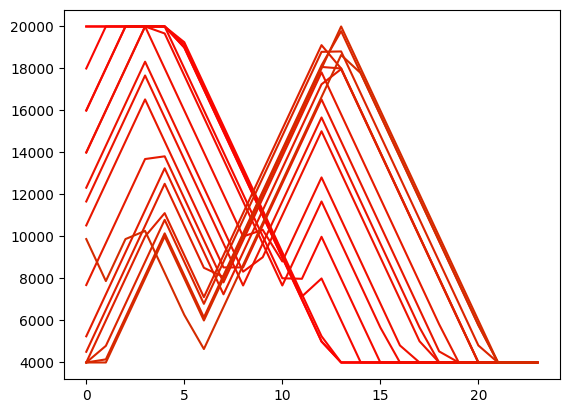

In [ ]:
for gwp_reduction in range(len(results)):
    if prod_study[gwp_reduction] is not None:
        plt.plot([prod_study[gwp_reduction]['HO', 'ATR_CCS_R', 0, hour] for hour in range(24)], color = (1 - gwp_reduction/100,gwp_reduction/100,0))

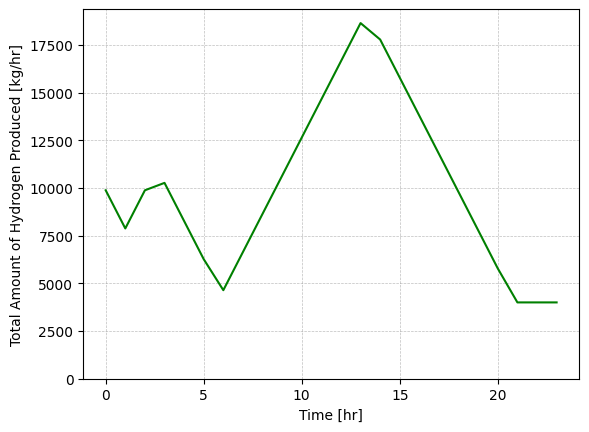

In [114]:
import matplotlib.pyplot as plt
plt.plot([prod_study[17]['HO', 'ATR_CCS_R', 0, hour] for hour in range(24)], color = 'g')

plt.xlabel('Time [hr]')
plt.ylabel('Total Amount of Hydrogen Produced [kg/hr]')
plt.ticklabel_format(style='sci', axis='x')  # For x-axis
plt.ticklabel_format(style='sci', axis='y')  # For y-axis
plt.ylim(bottom=0)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha = 0.5)


In [161]:
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
# from datetime import datetime, timedelta

# # Generate time labels
# time_labels = [datetime(2024, 1, 1) + timedelta(hours=i) for i in range(24)]

# # Plotting the data
# plt.plot(time_labels, [prod_study[0]['HO', 'ATR_CCS_R', 0, hour] for hour in range(24)], color='red', label="Base Case")
# plt.plot(time_labels, [prod_study[5]['HO', 'ATR_CCS_R', 0, hour] for hour in range(24)], color='darkorange', label="")
# plt.plot(time_labels, [prod_study[10]['HO', 'ATR_CCS_R', 0, hour] for hour in range(24)], color='gold', label="Study 10")
# plt.plot(time_labels, [prod_study[17]['HO', 'ATR_CCS_R', 0, hour] for hour in range(24)], color='yellowgreen', label="Study 15")

# # Labeling axes
# plt.xlabel('Time')
# plt.ylabel('Total Amount of Hydrogen Produced [kg/hr]')

# # Format the y-axis in scientific notation
# plt.ticklabel_format(style='sci', axis='y')  

# # Set limits for y and x axes
# plt.ylim(bottom=3000)
# plt.xlim([time_labels[0], time_labels[-1]])

# # Set custom time labels for the x-axis
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Hour:Minute format
# plt.xticks(time_labels[::3])  # Show every second hour for better spacing

# # Add grid
# plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# # Display legend
# plt.legend()

# # Show the plot
# plt.show()


C:\Users\marcopdsousa\AppData\Local\Temp\ipykernel_39080\3804237497.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlGn', len(data_sets))


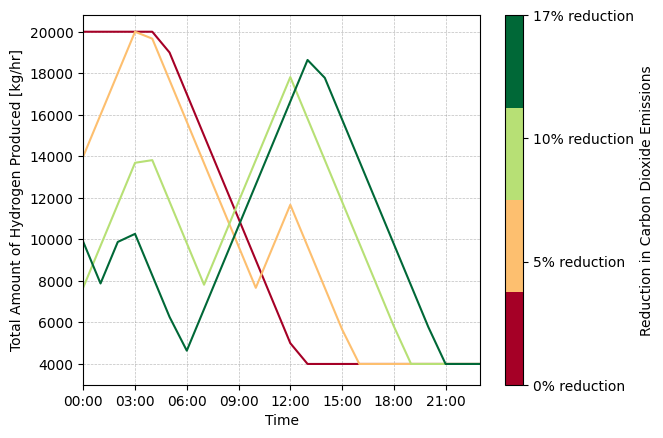

In [146]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import numpy as np

# Generate time labels
time_labels = [datetime(2024, 1, 1) + timedelta(hours=i) for i in range(24)]

# Data for plotting
data_sets = [0, 5, 10, 17]  # Indices of the different datasets

# Create a colormap from red to yellowgreen
cmap = plt.cm.get_cmap('RdYlGn', len(data_sets))

# Plot each dataset with its corresponding color
for i, study in enumerate(data_sets):
    plt.plot(time_labels, 
             [prod_study[study]['HO', 'ATR_CCS_R', 0, hour] for hour in range(24)], 
             color=cmap(i), label=f'Study {study}')

# Labeling axes
plt.xlabel('Time')
plt.ylabel('Total Amount of Hydrogen Produced [kg/hr]')

# Format the y-axis in scientific notation
plt.ticklabel_format(style='sci', axis='y')

# Set limits for y and x axes
plt.ylim(bottom=3000)
plt.xlim([time_labels[0], time_labels[-1]])

# Set custom time labels for the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # Hour:Minute format
plt.xticks(time_labels[::3])  # Show every second hour for better spacing

# Add grid
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Create a colorbar to represent the spectrum of the studies
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=len(data_sets) - 1))
sm.set_array([])  # Empty array for the colorbar
cbar = plt.colorbar(sm, ax=plt.gca(), ticks=np.linspace(0, len(data_sets) - 1, len(data_sets)))
cbar.set_label('Reduction in Carbon Dioxide Emissions')
cbar.set_ticks([0, 1, 2, 3])
cbar.set_ticklabels([f'{study}% reduction' for study in data_sets])

# Show the plot
plt.show()


In [158]:
# plt.plot([prod_study[5]['HO', 'ATR_CCS_R', 0, hour] for hour in range(24)], color = 'darkorange')

# plt.xlabel('Time [hr]')
# plt.ylabel('Total Amount of Hydrogen Produced [kg/hr]')
# plt.ticklabel_format(style='sci', axis='x')  # For x-axis
# plt.ticklabel_format(style='sci', axis='y')  # For y-axis
# plt.ylim(bottom=0)
# plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha = 0.5)

In [159]:
# plt.plot([prod_study[10]['HO', 'ATR_CCS_R', 0, hour] for hour in range(24)], color = 'gold')

# plt.xlabel('Time [hr]')
# plt.ylabel('Total Amount of Hydrogen Produced [kg/hr]')
# plt.ticklabel_format(style='sci', axis='x')  # For x-axis
# plt.ticklabel_format(style='sci', axis='y')  # For y-axis
# plt.ylim(bottom=0)
# plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha = 0.5)

In [160]:
# plt.plot([prod_study[15]['HO', 'ATR_CCS_R', 0, hour] for hour in range(24)], color = 'yellowgreen')

# plt.xlabel('Time [hr]')
# plt.ylabel('Total Amount of Hydrogen Produced [kg/hr]')
# plt.ticklabel_format(style='sci', axis='x')  # For x-axis
# plt.ticklabel_format(style='sci', axis='y')  # For y-axis
# plt.ylim(bottom=0)
# plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha = 0.5)

In [119]:
# for gwp_reduction in range(len(results)):
#     if prod_study[gwp_reduction] is not None:
#         plt.plot([prod_study[gwp_reduction]['HO', 'PEM', 0, hour] for hour in range(24)], color = (1 - gwp_reduction/100,gwp_reduction/100,0))

In [120]:
# for gwp_reduction in range(len(results)):
#     if prod_study[gwp_reduction] is not None:
#         plt.plot([prod_study[gwp_reduction]['HO', 'AWE', 0, hour] for hour in range(24)], color = (1 - gwp_reduction/100,gwp_reduction/100,0))

## STOP RIGHT HERE, DON'T PLAY AROUND WITH EXCEL SO MUCH 

In [ ]:
import pickle
with open('C:/Users/marcopdsousa/Documents/energiapy/Real-Time/res_red/res_red_0.pkl', 'rb') as file:
    data = pickle.load(file)
    print(data)

In [ ]:
# Load the pickle file
data = pd.read_pickle('C:/Users/marcopdsousa/Documents/energiapy/Real-Time/res_red/res_red_0.pkl')
df = pd.DataFrame(data)
selected_rows = df.loc[['objective', 'Cost', 'global_warming_potential_network']]
selected_rows.to_excel('C:/Users/marcopdsousa/Desktop/Dataframes/ERS Conf/res_red_0.xlsx', index=True)
#df = df.T
# # Check the type of the loaded object
# print(data.keys())
# df.to_excel('C:/Users/marcopdsousa/Desktop/Dataframes/Shell August 2024/res_red_0.xlsx', index=True)

df

In [ ]:
import pandas as pd
import os

# Directory paths
input_dir = 'C:/Users/marcopdsousa/Documents/energiapy/Real-Time/res_red/'
output_dir = 'C:/Users/marcopdsousa/Desktop/Dataframes/ERS Conf/Swami'

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Loop through the 100 .pkl files
for i in range(100):
    # Generate the file name
    input_file = os.path.join(input_dir, f'res_red_{i}.pkl')
    output_file = os.path.join(output_dir, f'res_red_{i}.xlsx')
    
    # Load the pickle file
    df = pd.read_pickle(input_file)
    df = pd.DataFrame(df)
    # Select the specific rows of interest
    selected_rows = df.loc[['objective', 'Cost', 'global_warming_potential_network']]
    
    # Save the selected rows to an Excel file
    selected_rows.to_excel(output_file, index=True)
    
    print(f"Processed and saved: {output_file}")


In [ ]:
import pandas as pd
import os

# Directory containing the Excel files
input_dir = 'C:/Users/marcopdsousa/Desktop/Dataframes/ERS Conf/Swami'

# Output file path
output_file = 'C:/Users/marcopdsousa/Desktop/Dataframes/ERS Conf/Swami/merged_ERS_res_red.xlsx'

# Initialize an empty list to hold the DataFrames
dfs = []

# Loop through each file in the directory
for file_name in os.listdir(input_dir):
    if file_name.endswith('.xlsx'):
        # Construct full file path
        file_path = os.path.join(input_dir, file_name)
        
        # Load the Excel file into a DataFrame
        df = pd.read_excel(file_path)
        
        # Optionally, add a column to identify the source file
        df['Source'] = file_name
        
        # Append the DataFrame to the list
        dfs.append(df)
        
        print(f"Loaded {file_name}")

# Concatenate all DataFrames in the list into one DataFrame
merged_df = pd.concat(dfs, ignore_index=True)

# Save the merged DataFrame to a single Excel file
merged_df.to_excel(output_file, index=False)

print(f"All files merged into {output_file}")


In [ ]:
# df = pd.DataFrame(data)
# df = df.T
# # Export the DataFrame to an Excel file,index=[0]
# df.to_excel('C:/Users/marcopdsousa/Desktop/Dataframes/Shell August 2024/res_red_0.xlsx', index=True)

In [ ]:
import pandas as pd

# Load the data from your Excel file (assuming it's saved as 'your_file.xlsx')
df = pd.read_excel('C:/Users/marcopdsousa/Desktop/Dataframes/ERS Conf/Swami/merged_ERS_res_red.xlsx')

# Separate out the data based on the "Unnamed: 0" column (which categorizes the rows)
df_objective = df[df['Unnamed: 0'] == 'objective']
df_gwp = df[df['Unnamed: 0'] == 'global_warming_potential_network']

# Merge both DataFrames based on the 'Source' or 'name' column (assuming these are unique)
df_merged = pd.merge(df_objective, df_gwp, on=['Source', 'name'], suffixes=('_objective', '_gwp'))

# Reorder the columns if necessary
df_final = df_merged[['Source', 'name', 'output_objective', 'output_gwp']]

# Save the organized data to a new Excel file
df_final.to_excel('C:/Users/marcopdsousa/Desktop/Dataframes/ERS Conf/Swami/organized_data.xlsx', index=False)

print("Data has been organized and saved as 'organized_data.xlsx'")


In [ ]:
# Load the pickle file
data = pd.read_pickle('C:/Users/marcopdsousa/Documents/energiapy/Real-Time/res_red/res_red_50.pkl')
df = pd.DataFrame(data)
df_extract = df.loc[['P']]
df_extract = df_extract.T
df_extract.to_excel('C:/Users/marcopdsousa/Desktop/Dataframes/ERS Conf/Swami/Details/res_red_50.xlsx', index=True)

## Minimization of the GWP 

In [ ]:
milp_gwp = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.MIN_GWP, demand_sign = 'eq')

In [ ]:
# # model.component

# from pyomo.environ import ConstraintList
# milp_gwp.cons4 = ConstraintList()
# for i in scales.scale_iter(2):
#     milp_gwp.cons4.add(expr = milp_gwp.P['HO', 'SMR', *i] >= 1000)

In [ ]:

from pyomo.environ import ConstraintList

ramping_limit = 5000

milp_gwp.cons2 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp.cons2.add(expr = milp_gwp.P['HO', 'SMRCCS', *i] - milp_gwp.P['HO', 'SMRCCS', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp.cons3 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp.cons3.add(expr = milp_gwp.P['HO', 'SMRCCS', *i] - milp_gwp.P['HO', 'SMRCCS', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] >= -ramping_limit)

# from pyomo.environ import ConstraintList, Binary, Var


# # Define the binary variable
# milp_gwp.ramping_up = Var(scales.scale_iter(1), within=Binary)

# ramping_limit = 5000

# milp_gwp.cons2 = ConstraintList()
# milp_gwp.cons3 = ConstraintList()

# for i in scales.scale_iter(1):
#     if i != (0,0):
#         previous_i = scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]
        
#         # Ramp up constraint
#         milp_gwp.cons2.add(expr = milp_cost.P['HO', 'SMR', *i] - milp_gwp.P['HO', 'SMR', *previous_i] <= ramping_limit)
        
#         # Ramp down constraint
#         milp_gwp.cons3.add(expr = milp_gwp.P['HO', 'SMR', *i] - milp_gwp.P['HO', 'SMR', *previous_i] >= -ramping_limit)
        
#         # Ensure if ramped up, cannot ramp down in the next step
#         milp_gwp.cons3.add(expr = milp_gwp.ramping_up[i] * (milp_cost.P['HO', 'SMR', *i] - milp_gwp.P['HO', 'SMR', *previous_i]) >= 0)
#         milp_gwp.cons3.add(expr = (1 - milp_gwp.ramping_up[i]) * (milp_cost.P['HO', 'SMR', *i] - milp_gwp.P['HO', 'SMR', *previous_i]) <= 0)

In [ ]:

ramping_limit1 = 8000

milp_gwp.cons4 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp.cons4.add(expr = milp_gwp.P['HO', 'ATR_CCS_R', *i] - milp_gwp.P['HO', 'ATR_CCS_R', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit1)

milp_gwp.cons5 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp.cons5.add(expr = milp_gwp.P['HO', 'ATR_CCS_R', *i] - milp_gwp.P['HO', 'ATR_CCS_R', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] >= -ramping_limit1)

milp_gwp.cons6 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp.cons6.add(expr = milp_gwp.P['HO', 'ATR_CCS_OC', *i] - milp_gwp.P['HO', 'ATR_CCS_OC', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit1)

milp_gwp.cons7 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp.cons7.add(expr = milp_gwp.P['HO', 'ATR_CCS_OC', *i] - milp_gwp.P['HO', 'ATR_CCS_OC', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] >= -ramping_limit1)        

milp_gwp.cons8 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp.cons8.add(expr = milp_gwp.P['HO', 'ATR_CCS_R_OC', *i] - milp_gwp.P['HO', 'ATR_CCS_R_OC', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit1)

milp_gwp.cons9 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp.cons9.add(expr = milp_gwp.P['HO', 'ATR_CCS_R_OC', *i] - milp_gwp.P['HO', 'ATR_CCS_R_OC', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] >= -ramping_limit1)  

In [ ]:
milp_gwp.objective_gwp_min.pprint()

In [ ]:
results_gwp = solve(scenario=scenario, instance=milp_gwp,
                     solver='gurobi', name=f"res_gwp", print_solversteps=True, saveformat = '.pkl')

In [ ]:
results_gwp.output['global_warming_potential_resource']

In [ ]:
results_gwp.output['global_warming_potential_location']

In [ ]:
results_gwp.output['Cost']

In [ ]:
# results_gwp.output['P_network']

In [ ]:
results_gwp.output['P']

In [ ]:
data = results_gwp.output['P']
df = pd.DataFrame(data,index=[0])
df = df.T
# Export the DataFrame to an Excel file
df.to_excel('C:/Users/marcopdsousa/Desktop/Dataframes/Shell August 2024/varyingGWPprocessexpanded.xlsx', index=True)

In [ ]:
results_gwp.output['Cost']

In [ ]:
# data = results_gwp.output['P']
# df = pd.DataFrame(data,index=[0])
# df = df.T
# # Export the DataFrame to an Excel file
# df.to_excel('C:/Users/marcopdsousa/Desktop/Dataframes/ScopeFormulation/mingwpP.xlsx', index=True)

EMISSION RESTRICTIONS

In [ ]:
milp_gwp_10 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

from energiapy.model.constraints.emission import constraint_global_warming_potential_network_reduction
constraint_global_warming_potential_network_reduction(instance= milp_gwp_10, network_scale_level = 0, gwp_reduction_pct = 10, gwp = results_cost.output['global_warming_potential_network'][0])

In [ ]:
from pyomo.environ import ConstraintList

ramping_limit = 3

milp_gwp_10.cons1 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_10.cons1.add(expr = milp_gwp_10.P['HO', 'PEM', *i] - milp_gwp_10.P['HO', 'PEM', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_10.cons2 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_10.cons2.add(expr = milp_gwp_10.P['HO', 'SMR', *i] - milp_gwp_10.P['HO', 'SMR', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_10.cons3 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_10.cons3.add(expr = milp_gwp_10.P['HO', 'SMRCCS', *i] - milp_gwp_10.P['HO', 'SMRCCS', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_10.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    milp_gwp_10.cons4.add(expr = milp_gwp_10.P['HO', 'SMR', *i] >= 5)

In [ ]:
results_gwp_10 = solve(scenario=scenario, instance=milp_gwp_10,
                     solver='gurobi', name=f"res_gwp_10", print_solversteps=True, saveformat = '.pkl')

In [ ]:
results_gwp_10.output['objective']

In [ ]:
results_gwp_10.output['global_warming_potential_location']

In [ ]:
results_gwp_10.output['P']

In [ ]:
# data = results_gwp_10.output['P']
# df = pd.DataFrame(data,index=[0])
# df = df.T
# # Export the DataFrame to an Excel file
# df.to_excel('C:/Users/marcopdsousa/Desktop/Dataframes/mingwpprod10.xlsx', index=True)

In [ ]:
# data = results_gwp_10.output['global_warming_potential_resource']
# df = pd.DataFrame(data,index=[0])
# df = df.T
# # Export the DataFrame to an Excel file
# df.to_excel('C:/Users/marcopdsousa/Desktop/Dataframes/mingwp10resource_emission.xlsx', index=True)

In [ ]:
results_cost.output['global_warming_potential_resource']

In [ ]:
results_gwp_10.output['global_warming_potential_resource']

In [ ]:
milp_gwp_20 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

from energiapy.model.constraints.emission import constraint_global_warming_potential_network_reduction
constraint_global_warming_potential_network_reduction(instance= milp_gwp_20, network_scale_level = 0, gwp_reduction_pct = 20, gwp = results_cost.output['global_warming_potential_network'][0])


In [ ]:
from pyomo.environ import ConstraintList

ramping_limit = 3

milp_gwp_20.cons1 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_20.cons1.add(expr = milp_gwp_20.P['HO', 'PEM', *i] - milp_gwp_20.P['HO', 'PEM', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_20.cons2 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_20.cons2.add(expr = milp_gwp_20.P['HO', 'SMR', *i] - milp_gwp_20.P['HO', 'SMR', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_20.cons3 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_20.cons3.add(expr = milp_gwp_20.P['HO', 'SMRCCS', *i] - milp_gwp_20.P['HO', 'SMRCCS', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_20.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    milp_gwp_20.cons4.add(expr = milp_gwp_20.P['HO', 'SMR', *i] >= 5)

In [ ]:
results_gwp_20 = solve(scenario=scenario, instance=milp_gwp_20,
                     solver='gurobi', name=f"res_gwp_20", print_solversteps=True, saveformat = '.pkl')

In [ ]:
results_gwp_20.output['objective']


In [ ]:
results_gwp_20.output['P']

In [ ]:
results_gwp_20.output['global_warming_potential_location']

In [ ]:
results_gwp_20.output['global_warming_potential_resource']

In [ ]:
results_gwp_20.output['P_network']

In [ ]:
# data = results_gwp_20.output['P']
# df = pd.DataFrame(data,index=[0])
# df = df.T
# # Export the DataFrame to an Excel file
# df.to_excel('C:/Users/marcopdsousa/Desktop/Dataframes/mingwpprod20.xlsx', index=True)

In [ ]:
# data = results_gwp_20.output['global_warming_potential_resource']
# df = pd.DataFrame(data,index=[0])
# df = df.T
# # Export the DataFrame to an Excel file
# df.to_excel('C:/Users/marcopdsousa/Desktop/Dataframes/mingwp20resource_emission.xlsx', index=True)

In [ ]:
results_gwp_20.output["objective"]

In [ ]:
milp_gwp_30 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

from energiapy.model.constraints.emission import constraint_global_warming_potential_network_reduction
constraint_global_warming_potential_network_reduction(instance= milp_gwp_30, network_scale_level = 0, gwp_reduction_pct = 30, gwp = results_cost.output['global_warming_potential_network'][0])





In [ ]:
from pyomo.environ import ConstraintList

ramping_limit = 3

milp_gwp_30.cons1 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_30.cons1.add(expr = milp_gwp_30.P['HO', 'PEM', *i] - milp_gwp_30.P['HO', 'PEM', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_30.cons2 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_30.cons2.add(expr = milp_gwp_30.P['HO', 'SMR', *i] - milp_gwp_30.P['HO', 'SMR', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_30.cons3 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_30.cons3.add(expr = milp_gwp_30.P['HO', 'SMRCCS', *i] - milp_gwp_30.P['HO', 'SMRCCS', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_30.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    milp_gwp_30.cons4.add(expr = milp_gwp_30.P['HO', 'SMR', *i] >= 5)

In [ ]:
results_gwp_30 = solve(scenario=scenario, instance=milp_gwp_30,
                     solver='gurobi', name=f"res_gwp_30", print_solversteps=True, saveformat = '.pkl')

In [ ]:

results_gwp_30.output['objective']

In [ ]:
results_gwp_30.output['P']

In [ ]:
results_gwp_30.output['global_warming_potential_location']

In [ ]:
results_gwp_30.output['P_network']

In [ ]:
plot_results.cost(results=results_gwp_30, x=CostX.PROCESS_WISE,
                  y=CostY.TOTAL, location='HO', fig_size=(11, 6))

In [ ]:
# data = results_gwp_30.output['P']
# df = pd.DataFrame(data,index=[0])
# df = df.T
# # Export the DataFrame to an Excel file
# df.to_excel('C:/Users/marcopdsousa/Desktop/Dataframes/mingwpprod30.xlsx', index=True)

In [ ]:
results_gwp_30.output["objective"]

In [ ]:
# data = results_gwp_30.output['global_warming_potential_resource']
# df = pd.DataFrame(data,index=[0])
# df = df.T
# # Export the DataFrame to an Excel file
# df.to_excel('C:/Users/marcopdsousa/Desktop/Dataframes/mingwp30resource_emission.xlsx', index=True)

In [ ]:
milp_gwp_40 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

from energiapy.model.constraints.emission import constraint_global_warming_potential_network_reduction
constraint_global_warming_potential_network_reduction(instance= milp_gwp_40, network_scale_level = 0, gwp_reduction_pct = 40, gwp = results_cost.output['global_warming_potential_network'][0])


In [ ]:
from pyomo.environ import ConstraintList

ramping_limit = 3

milp_gwp_40.cons1 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_40.cons1.add(expr = milp_gwp_40.P['HO', 'PEM', *i] - milp_gwp_40.P['HO', 'PEM', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_40.cons2 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_40.cons2.add(expr = milp_gwp_40.P['HO', 'SMR', *i] - milp_gwp_40.P['HO', 'SMR', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_40.cons3 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_40.cons3.add(expr = milp_gwp_40.P['HO', 'SMRCCS', *i] - milp_gwp_40.P['HO', 'SMRCCS', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_40.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    milp_gwp_40.cons4.add(expr = milp_gwp_40.P['HO', 'SMR', *i] >= 5)

In [ ]:
results_gwp_40 = solve(scenario=scenario, instance=milp_gwp_40,
                     solver='gurobi', name=f"res_gwp_40", print_solversteps=True, saveformat = '.pkl')

In [ ]:
results_gwp_40.output['objective']

In [ ]:
results_gwp_40.output['global_warming_potential_location']

In [ ]:
results_gwp_40.output['global_warming_potential_resource']

In [ ]:
results_gwp_40.output['P_network']

In [ ]:
results_gwp_40.output['P']

In [ ]:
plot_results.cost(results=results_gwp_40, x=CostX.PROCESS_WISE,
                  y=CostY.TOTAL, location='HO', fig_size=(11, 6))

In [ ]:
plot_results.schedule(results = results_gwp_40, y_axis= 'P', component = 'SMR', location='HO')
plot_results.schedule(results = results_gwp_40, y_axis= 'P', component = 'SMRCCS', location='HO')


In [ ]:
# data = results_gwp_40.output['P']
# df = pd.DataFrame(data,index=[0])
# df = df.T
# # Export the DataFrame to an Excel file
# df.to_excel('C:/Users/marcopdsousa/Desktop/Dataframes/mingwpprod40.xlsx', index=True)

In [ ]:
# data = results_gwp_40.output['global_warming_potential_resource']
# df = pd.DataFrame(data,index=[0])
# df = df.T
# # Export the DataFrame to an Excel file
# df.to_excel('C:/Users/marcopdsousa/Desktop/Dataframes/mingwp40resource_emission.xlsx', index=True)

In [ ]:
results_gwp_40.output["objective"]

In [ ]:
milp_gwp_50 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

from energiapy.model.constraints.emission import constraint_global_warming_potential_network_reduction
constraint_global_warming_potential_network_reduction(instance= milp_gwp_50, network_scale_level = 0, gwp_reduction_pct = 50, gwp = results_cost.output['global_warming_potential_network'][0])

In [ ]:
from pyomo.environ import ConstraintList

ramping_limit = 3

milp_gwp_50.cons1 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_50.cons1.add(expr = milp_gwp_50.P['HO', 'PEM', *i] - milp_gwp_50.P['HO', 'PEM', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_50.cons2 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_50.cons2.add(expr = milp_gwp_50.P['HO', 'SMR', *i] - milp_gwp_50.P['HO', 'SMR', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_50.cons3 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_50.cons3.add(expr = milp_gwp_50.P['HO', 'SMRCCS', *i] - milp_gwp_50.P['HO', 'SMRCCS', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_50.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    milp_gwp_50.cons4.add(expr = milp_gwp_50.P['HO', 'SMR', *i] >= 5)

In [ ]:
results_gwp_50 = solve(scenario=scenario, instance=milp_gwp_50,
                     solver='gurobi', name=f"res_gwp_50", print_solversteps=True, saveformat = '.pkl')

In [ ]:
# data = results_gwp_50.output['P']
# df = pd.DataFrame(data,index=[0])
# df = df.T
# # Export the DataFrame to an Excel file
# df.to_excel('C:/Users/marcopdsousa/Desktop/Dataframes/mingwpprod50.xlsx', index=True)

In [ ]:
# data = results_gwp_50.output['global_warming_potential_resource']
# df = pd.DataFrame(data,index=[0])
# df = df.T
# # Export the DataFrame to an Excel file
# df.to_excel('C:/Users/marcopdsousa/Desktop/Dataframes/mingwp50resource_emission.xlsx', index=True)

In [ ]:
results_gwp_50.output["objective"]

In [ ]:
results_gwp_50.output['global_warming_potential_location']

In [ ]:
milp_gwp_60 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

from energiapy.model.constraints.emission import constraint_global_warming_potential_network_reduction
constraint_global_warming_potential_network_reduction(instance= milp_gwp_60, network_scale_level = 0, gwp_reduction_pct = 60, gwp = results_cost.output['global_warming_potential_network'][0])

In [ ]:
from pyomo.environ import ConstraintList

ramping_limit = 3

milp_gwp_60.cons1 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_60.cons1.add(expr = milp_gwp_60.P['HO', 'PEM', *i] - milp_gwp_60.P['HO', 'PEM', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_60.cons2 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_60.cons2.add(expr = milp_gwp_60.P['HO', 'SMR', *i] - milp_gwp_60.P['HO', 'SMR', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_60.cons3 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_60.cons3.add(expr = milp_gwp_60.P['HO', 'SMRCCS', *i] - milp_gwp_60.P['HO', 'SMRCCS', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_60.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    milp_gwp_60.cons4.add(expr = milp_gwp_60.P['HO', 'SMR', *i] >= 5)

In [ ]:
results_gwp_60 = solve(scenario=scenario, instance=milp_gwp_60,
                     solver='gurobi', name=f"res_gwp_60", print_solversteps=True, saveformat = '.pkl')

In [ ]:
plot_results.schedule(results = results_gwp_60, y_axis= 'P', component = 'SMR', location='HO')
plot_results.schedule(results = results_gwp_60, y_axis= 'P', component = 'SMRCCS', location='HO')
plot_results.schedule(results = results_gwp_60, y_axis= 'P', component = 'PEM', location='HO')

In [ ]:
# data = results_gwp_60.output['P']
# df = pd.DataFrame(data,index=[0])
# df = df.T
# # Export the DataFrame to an Excel file
# df.to_excel('C:/Users/marcopdsousa/Desktop/Dataframes/mingwpprod60.xlsx', index=True)

In [ ]:
# data = results_gwp_60.output['global_warming_potential_resource']
# df = pd.DataFrame(data,index=[0])
# df = df.T
# # Export the DataFrame to an Excel file
# df.to_excel('C:/Users/marcopdsousa/Desktop/Dataframes/mingwp60resource_emission.xlsx', index=True)

In [ ]:
results_gwp_60.output["objective"]

In [ ]:
results_gwp_60.output["P"]

In [ ]:
results_gwp_60.output['global_warming_potential_location']

In [ ]:
results_gwp_60.output['global_warming_potential_resource']

In [ ]:
milp_gwp_70 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

from energiapy.model.constraints.emission import constraint_global_warming_potential_network_reduction
constraint_global_warming_potential_network_reduction(instance= milp_gwp_70, network_scale_level = 0, gwp_reduction_pct = 70, gwp = results_cost.output['global_warming_potential_network'][0])

In [ ]:
from pyomo.environ import ConstraintList

ramping_limit = 3

milp_gwp_70.cons1 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_70.cons1.add(expr = milp_gwp_70.P['HO', 'PEM', *i] - milp_gwp_70.P['HO', 'PEM', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_70.cons2 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_70.cons2.add(expr = milp_gwp_70.P['HO', 'SMR', *i] - milp_gwp_70.P['HO', 'SMR', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_70.cons3 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_70.cons3.add(expr = milp_gwp_70.P['HO', 'SMRCCS', *i] - milp_gwp_70.P['HO', 'SMRCCS', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_70.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    milp_gwp_70.cons4.add(expr = milp_gwp_70.P['HO', 'SMR', *i] >= 5)

In [ ]:
results_gwp_70 = solve(scenario=scenario, instance=milp_gwp_70,
                     solver='gurobi', name=f"res_gwp_70", print_solversteps=True, saveformat = '.pkl')

In [ ]:
# data = results_gwp_70.output['P']
# df = pd.DataFrame(data,index=[0])
# df = df.T
# # Export the DataFrame to an Excel file
# df.to_excel('C:/Users/marcopdsousa/Desktop/Dataframes/mingwpprod70.xlsx', index=True)

In [ ]:
# data = results_gwp_70.output['global_warming_potential_resource']
# df = pd.DataFrame(data,index=[0])
# df = df.T
# # Export the DataFrame to an Excel file
# df.to_excel('C:/Users/marcopdsousa/Desktop/Dataframes/mingwp70resource_emission.xlsx', index=True)

In [ ]:
results_gwp_70.output["objective"]

In [ ]:
results_gwp_70.output['global_warming_potential_resource']

In [ ]:
results_gwp_70.output["P"]

In [ ]:
results_gwp_70.output['global_warming_potential_location']

In [ ]:
milp_gwp_75 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

from energiapy.model.constraints.emission import constraint_global_warming_potential_network_reduction
constraint_global_warming_potential_network_reduction(instance= milp_gwp_75, network_scale_level = 0, gwp_reduction_pct = 75, gwp = results_cost.output['global_warming_potential_network'][0])

In [ ]:
from pyomo.environ import ConstraintList

ramping_limit = 3

milp_gwp_75.cons1 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_75.cons1.add(expr = milp_gwp_75.P['HO', 'PEM', *i] - milp_gwp_75.P['HO', 'PEM', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_75.cons2 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_75.cons2.add(expr = milp_gwp_75.P['HO', 'SMR', *i] - milp_gwp_75.P['HO', 'SMR', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_75.cons3 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_75.cons3.add(expr = milp_gwp_75.P['HO', 'SMRCCS', *i] - milp_gwp_75.P['HO', 'SMRCCS', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_75.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    milp_gwp_75.cons4.add(expr = milp_gwp_75.P['HO', 'SMR', *i] >= 5)

In [ ]:
results_gwp_75 = solve(scenario=scenario, instance=milp_gwp_75,
                     solver='gurobi', name=f"res_gwp_75", print_solversteps=True, saveformat = '.pkl')

In [ ]:
# data = results_gwp_75.output['P']
# df = pd.DataFrame(data,index=[0])
# df = df.T
# # Export the DataFrame to an Excel file
# df.to_excel('C:/Users/marcopdsousa/Desktop/Dataframes/mingwpprod75.xlsx', index=True)

In [ ]:
results_gwp_75.output["objective"]

In [ ]:
results_gwp_75.output["P"]

In [ ]:
results_gwp_75.output['global_warming_potential_location']

In [ ]:
milp_gwp_78 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

from energiapy.model.constraints.emission import constraint_global_warming_potential_network_reduction
constraint_global_warming_potential_network_reduction(instance= milp_gwp_78, network_scale_level = 0, gwp_reduction_pct = 78, gwp = results_cost.output['global_warming_potential_network'][0])

In [ ]:
from pyomo.environ import ConstraintList

ramping_limit = 3

milp_gwp_78.cons1 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_78.cons1.add(expr = milp_gwp_78.P['HO', 'PEM', *i] - milp_gwp_78.P['HO', 'PEM', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_78.cons2 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_78.cons2.add(expr = milp_gwp_78.P['HO', 'SMR', *i] - milp_gwp_78.P['HO', 'SMR', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_78.cons3 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_78.cons3.add(expr = milp_gwp_78.P['HO', 'SMRCCS', *i] - milp_gwp_78.P['HO', 'SMRCCS', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_78.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    milp_gwp_78.cons4.add(expr = milp_gwp_78.P['HO', 'SMR', *i] >= 5)

In [ ]:
results_gwp_78 = solve(scenario=scenario, instance=milp_gwp_78,
                     solver='gurobi', name=f"res_gwp_78", print_solversteps=True, saveformat = '.pkl')

In [ ]:
results_gwp_78.output['objective']

In [ ]:
results_gwp_78.output['global_warming_potential_location']

In [ ]:
results_gwp_78.output["P"]

In [ ]:
# data = results_gwp_78.output['P']
# df = pd.DataFrame(data,index=[0])
# df = df.T
# # Export the DataFrame to an Excel file
# df.to_excel('C:/Users/marcopdsousa/Desktop/Dataframes/mingwpprod78.xlsx', index=True)

In [ ]:
plot_results.cost(results=results_gwp_78, x=CostX.PROCESS_WISE,
                  y=CostY.TOTAL, location='HO', fig_size=(11, 6))

In [ ]:
milp_gwp_79 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

from energiapy.model.constraints.emission import constraint_global_warming_potential_network_reduction
constraint_global_warming_potential_network_reduction(instance= milp_gwp_79, network_scale_level = 0, gwp_reduction_pct = 79, gwp = results_cost.output['global_warming_potential_network'][0])

In [ ]:
from pyomo.environ import ConstraintList

ramping_limit = 3

milp_gwp_79.cons1 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_79.cons1.add(expr = milp_gwp_79.P['HO', 'PEM', *i] - milp_gwp_79.P['HO', 'PEM', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_79.cons2 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_79.cons2.add(expr = milp_gwp_79.P['HO', 'SMR', *i] - milp_gwp_79.P['HO', 'SMR', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_79.cons3 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_79.cons3.add(expr = milp_gwp_79.P['HO', 'SMRCCS', *i] - milp_gwp_79.P['HO', 'SMRCCS', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_79.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    milp_gwp_79.cons4.add(expr = milp_gwp_79.P['HO', 'SMR', *i] >= 5)

In [ ]:
results_gwp_79 = solve(scenario=scenario, instance=milp_gwp_79,
                     solver='gurobi', name=f"res_gwp_79", print_solversteps=True, saveformat = '.pkl')

In [ ]:
results_gwp_79.output['objective']

In [ ]:
results_gwp_79.output['global_warming_potential_location']

In [ ]:
results_gwp_79.output['P']

In [ ]:
milp_gwp_85 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

from energiapy.model.constraints.emission import constraint_global_warming_potential_network_reduction
constraint_global_warming_potential_network_reduction(instance= milp_gwp_85, network_scale_level = 0, gwp_reduction_pct = 85, gwp = results_cost.output['global_warming_potential_network'][0])

In [ ]:
from pyomo.environ import ConstraintList

ramping_limit = 3

milp_gwp_85.cons1 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_85.cons1.add(expr = milp_gwp_85.P['HO', 'PEM', *i] - milp_gwp_85.P['HO', 'PEM', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_85.cons2 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_85.cons2.add(expr = milp_gwp_85.P['HO', 'SMR', *i] - milp_gwp_85.P['HO', 'SMR', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_85.cons3 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_85.cons3.add(expr = milp_gwp_85.P['HO', 'SMRCCS', *i] - milp_gwp_85.P['HO', 'SMRCCS', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_85.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    milp_gwp_85.cons4.add(expr = milp_gwp_85.P['HO', 'SMR', *i] >= 5)

In [ ]:
results_gwp_85 = solve(scenario=scenario, instance=milp_gwp_85,
                     solver='gurobi', name=f"res_gwp_85", print_solversteps=True, saveformat = '.pkl')

In [ ]:
# data = results_gwp_85.output['P']
# df = pd.DataFrame(data,index=[0])
# df = df.T
# # Export the DataFrame to an Excel file
# df.to_excel('C:/Users/marcopdsousa/Desktop/Dataframes/mingwpprod85.xlsx', index=True)

In [ ]:
results_gwp_85.output['objective']

In [ ]:
results_gwp_85.output['global_warming_potential_location']

In [ ]:
results_gwp_85.output['P']

In [ ]:
milp_gwp_80 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

from energiapy.model.constraints.emission import constraint_global_warming_potential_network_reduction
constraint_global_warming_potential_network_reduction(instance= milp_gwp_80, network_scale_level = 0, gwp_reduction_pct = 80, gwp = results_cost.output['global_warming_potential_network'][0])

In [ ]:
from pyomo.environ import ConstraintList

ramping_limit = 3

milp_gwp_80.cons1 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_80.cons1.add(expr = milp_gwp_80.P['HO', 'PEM', *i] - milp_gwp_80.P['HO', 'PEM', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_80.cons2 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_80.cons2.add(expr = milp_gwp_80.P['HO', 'SMR', *i] - milp_gwp_80.P['HO', 'SMR', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_80.cons3 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_80.cons3.add(expr = milp_gwp_80.P['HO', 'SMRCCS', *i] - milp_gwp_80.P['HO', 'SMRCCS', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_80.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    milp_gwp_80.cons4.add(expr = milp_gwp_80.P['HO', 'SMR', *i] >= 5)

In [ ]:
results_gwp_80 = solve(scenario=scenario, instance=milp_gwp_80,
                     solver='gurobi', name=f"res_gwp_80", print_solversteps=True, saveformat = '.pkl')

In [ ]:
# data = results_gwp_80.output['P']
# df = pd.DataFrame(data,index=[0])
# df = df.T
# # Export the DataFrame to an Excel file
# df.to_excel('C:/Users/marcopdsousa/Desktop/Dataframes/mingwpprod80.xlsx', index=True)

In [ ]:
# data = results_gwp_80.output['global_warming_potential_resource']
# df = pd.DataFrame(data,index=[0])
# df = df.T
# # Export the DataFrame to an Excel file
# df.to_excel('C:/Users/marcopdsousa/Desktop/Dataframes/mingwp80resource_emission.xlsx', index=True)

In [ ]:
results_gwp_80.output['objective']

In [ ]:
results_gwp_80.output['global_warming_potential_location']

In [ ]:
milp_gwp_90 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

from energiapy.model.constraints.emission import constraint_global_warming_potential_network_reduction
constraint_global_warming_potential_network_reduction(instance= milp_gwp_90, network_scale_level = 0, gwp_reduction_pct = 90, gwp = results_cost.output['global_warming_potential_network'][0])

In [ ]:
from pyomo.environ import ConstraintList

ramping_limit = 3

milp_gwp_90.cons1 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_90.cons1.add(expr = milp_gwp_90.P['HO', 'PEM', *i] - milp_gwp_90.P['HO', 'PEM', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_90.cons2 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_90.cons2.add(expr = milp_gwp_90.P['HO', 'SMR', *i] - milp_gwp_90.P['HO', 'SMR', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_90.cons3 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_90.cons3.add(expr = milp_gwp_90.P['HO', 'SMRCCS', *i] - milp_gwp_90.P['HO', 'SMRCCS', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_90.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    milp_gwp_90.cons4.add(expr = milp_gwp_90.P['HO', 'SMR', *i] >= 5)

In [ ]:
results_gwp_90 = solve(scenario=scenario, instance=milp_gwp_90,
                     solver='gurobi', name=f"res_gwp_90", print_solversteps=True, saveformat = '.pkl')

In [ ]:
# data = results_gwp_90.output['P']
# df = pd.DataFrame(data,index=[0])
# df = df.T
# # Export the DataFrame to an Excel file
# df.to_excel('C:/Users/marcopdsousa/Desktop/Dataframes/mingwpprod90.xlsx', index=True)

In [ ]:
# data = results_gwp_90.output['global_warming_potential_resource']
# df = pd.DataFrame(data,index=[0])
# df = df.T
# # Export the DataFrame to an Excel file
# df.to_excel('C:/Users/marcopdsousa/Desktop/Dataframes/mingwp90resource_emission.xlsx', index=True)

In [ ]:
results_gwp_90.output['objective']

In [ ]:
results_gwp_90.output['global_warming_potential_location']

In [ ]:
results_gwp_90.output['P']

In [ ]:
milp_gwp_92 = formulate(scenario=scenario, constraints={Constraints.COST, Constraints.INVENTORY, Constraints.PRODUCTION,
                     Constraints.RESOURCE_BALANCE, Constraints.NETWORK, Constraints.DEMAND, Constraints.EMISSION}, objective=Objective.COST, demand_sign = 'eq')

from energiapy.model.constraints.emission import constraint_global_warming_potential_network_reduction
constraint_global_warming_potential_network_reduction(instance= milp_gwp_92, network_scale_level = 0, gwp_reduction_pct = 92, gwp = results_cost.output['global_warming_potential_network'][0])

In [ ]:
from pyomo.environ import ConstraintList

ramping_limit = 3

milp_gwp_92.cons1 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_92.cons1.add(expr = milp_gwp_92.P['HO', 'PEM', *i] - milp_gwp_92.P['HO', 'PEM', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_92.cons2 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_92.cons2.add(expr = milp_gwp_92.P['HO', 'SMR', *i] - milp_gwp_92.P['HO', 'SMR', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_92.cons3 = ConstraintList()
for i in scales.scale_iter(1):
    if i != (0,0):
        milp_gwp_92.cons3.add(expr = milp_gwp_92.P['HO', 'SMRCCS', *i] - milp_gwp_92.P['HO', 'SMRCCS', *scales.scale_iter(2)[scales.scale_iter(1).index(i) - 1]] <= ramping_limit)

milp_gwp_92.cons4 = ConstraintList()
for i in scales.scale_iter(2):
    milp_gwp_92.cons4.add(expr = milp_gwp_92.P['HO', 'SMR', *i] >= 5)

In [ ]:
results_gwp_92 = solve(scenario=scenario, instance=milp_gwp_92,
                     solver='gurobi', name=f"res_gwp_92", print_solversteps=True, saveformat = '.pkl')

In [ ]:
results_gwp_92.output['objective']

In [ ]:
results_gwp_92.output['global_warming_potential_location']

In [ ]:
results_gwp_92.output['P']

In [ ]:
# data = results_gwp_92.output['P']
# df = pd.DataFrame(data,index=[0])
# df = df.T
# # Export the DataFrame to an Excel file
# df.to_excel('C:/Users/marcopdsousa/Desktop/Dataframes/mingwpprod92.xlsx', index=True)